📍 CCTV 기반 실시간 탐지 중요도 시각화 작업 정리
1. 목표 정의
CCTV 탐지 이력 데이터를 바탕으로 도로망 그래프(G)의 노드별 실시간 단속 중요도(weight) 를 계산

탐지 이력이 최근일수록 더 높은 가중치를 갖도록 설계

계산된 가중치를 바탕으로 지도 상에서 노드의 색상으로 시각화

2. 사용한 데이터
✅ CCTV기반단속개별건수.csv
단속일시, 위도, 경도 정보를 포함

CCTV별 단속 이력과 위치 정보가 이미 연결되어 있는 전처리된 탐지 로그 데이터

3. 그래프 기반 처리
osmnx를 이용해 서초구 도로망 그래프(G) 불러옴

탐지 이력의 위도/경도 좌표를 가장 가까운 그래프 노드에 매핑 (KDTree 사용)

그래프의 노드 ID를 기준으로 탐지 건수 및 중요도 계산

4. 가중치(weight) 계산 방식
현재 시각(now_time) 이전의 탐지 이력만을 활용

각 단속 건에 대해 지수적 시간 감쇠(weight = exp(-λ × 경과시간)) 적용

최근 단속일수록 높은 값, 오래된 단속일수록 낮은 값 부여

노드별로 가중치를 합산하여 최종 importance 계산

5. 시각화 방식
각 노드의 weight를 색상으로 표현:

높은 weight → 진한 빨강

낮은 weight → 흰색

matplotlib의 Reds colormap 사용

컬러바를 통해 weight 범위와 시각적 강도를 명확하게 전달

지도 배경은 black, 도로는 gray로 설정하여 contrast 강조

## Import Library

In [1]:
import osmnx as ox
from geopy.distance import geodesic
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import folium
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from scipy.spatial import cKDTree
import lightgbm as lgb

## Data Load & Split

In [2]:
cctv_df = pd.read_csv('../../../Data/서초구주정차단속및CCTV정제데이터/CCTV기반단속개별건수.csv', encoding='cp949')
normal_df = pd.read_csv('../../../Data/서초구주정차단속및CCTV정제데이터/일반단속개별건수_geocoded.csv', encoding='cp949')

train_size = 0.7
val_size = 0.15
test_size = 0.15
seed = 42

# test set 분리
cctv_train_val, cctv_test   = train_test_split(cctv_df,   test_size=test_size, random_state=seed)
norm_train_val, norm_test   = train_test_split(normal_df, test_size=test_size, random_state=seed)

# train/val 비율 재계산
val_ratio = val_size / (train_size + val_size)

# train/val set 분리
cctv_train, cctv_val = train_test_split(cctv_train_val, test_size=val_ratio, random_state=seed)
norm_train, norm_val = train_test_split(norm_train_val, test_size=val_ratio, random_state=seed)

# 서초구 CCTV 정보
cctv_info = pd.read_excel("../../../Data/전국CCTV표준데이터.xlsx")
seocho_cctv = cctv_info[cctv_info['소재지도로명주소'].str.contains("서초구", na=False)]
seocho_cctv.rename(columns={"WGS84위도" : '위도', 'WGS84경도' : '경도'}, inplace=True)


c:\Users\chobh\AppData\Local\anaconda3\envs\bigProject\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\2021845063.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seocho_cctv.rename(columns={"WGS84위도" : '위도', 'WGS84경도' : '경도'}, inplace=True)


## Construct Graph Data

노드 수: 3057, 엣지 수: 8550


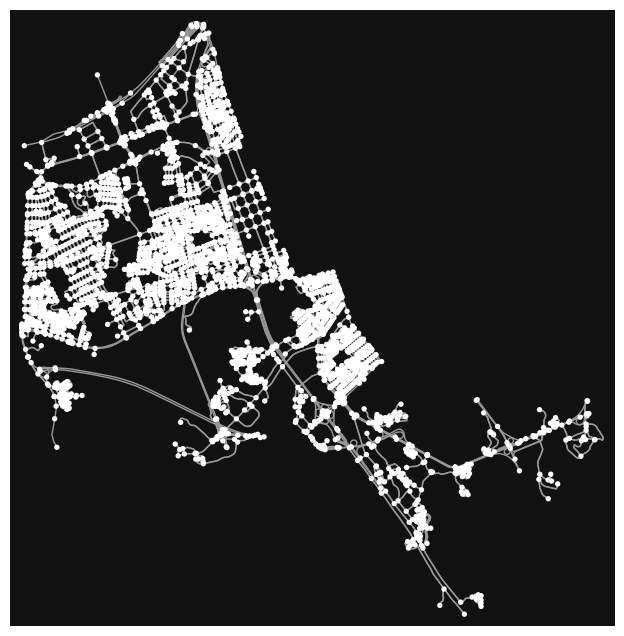

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# 기본 그래프 정보 불러오기

# 1. 서초구의 도로망 그래프 불러오기
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')

# 2. 기본 정보 출력
print(f"노드 수: {len(G.nodes)}, 엣지 수: {len(G.edges)}")

# 3. 시각화 (선택)
ox.plot_graph(G, figsize=(8,8))

In [4]:
def count_viloations_per_node(df, G):
    '''
    일반 단속 데이터를 이용해 각 그래프 노드 별 단속 건수 집계 함수
    '''

    # 그래프 노드 위치 정보
    nodes = ox.graph_to_gdfs(G, edges=False)
    node_coords = np.array(list(zip(nodes['y'], nodes['x'])))
    tree = cKDTree(node_coords)

    # 단속 위치 -> 최근접 노드 매핑
    df = df.dropna(subset=['위도', '경도'])
    coords = df[['위도', '경도']].values
    _, idx = tree.query(coords, k=1)
    nearest_node_ids = nodes.iloc[idx].index

    # 노드별 건수 집계
    violation_counts = pd.Series(nearest_node_ids).value_counts().to_dict()

    return violation_counts

In [5]:
def visualize_viloation_counts(G, violation_counts, colormap='seismic'):
    """
    G: networkx 그래프
    violation_counts: 노드 ID → 단속 건수 dict
    cmap_name: matplotlib colormap 이름
    """
     
     # 모든 노드 기본값 0 부여
    for node in G.nodes:
        G.nodes[node]['violation_count'] = violation_counts.get(node, 0)

    # 단속 건수 리스트
    counts = np.array([G.nodes[n]['violation_count'] for n in G.nodes])

    # 시각화용 통계 추출
    vmin = counts.min()
    vmax = counts.max()
    vcenter = np.median(counts)

    norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    cmap = cm.get_cmap(colormap)

    node_colors = [cmap(norm(G.nodes[n]['violation_count'])) for n in G.nodes]
    

    fig, ax = ox.plot_graph(
        G,
        node_color=node_colors,
        node_size=10,
        node_zorder=2,
        bgcolor='black',
        edge_color='gray',
        edge_linewidth=0.5,
        edge_alpha=0.5,
        show=False,
        close=False,
        figsize=(10, 10)
    )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
    cbar.set_label("단속 건수", color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    plt.title("Node-level Violation Counts (Normalized)", color='white')
    plt.tight_layout()
    plt.show()

C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\4071663358.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\4071663358.py:48: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\4071663358.py:48: UserWarning: Glyph 49549 (\N{HANGUL SYLLABLE SOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\4071663358.py:48: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\4071663358.py:48: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  pl

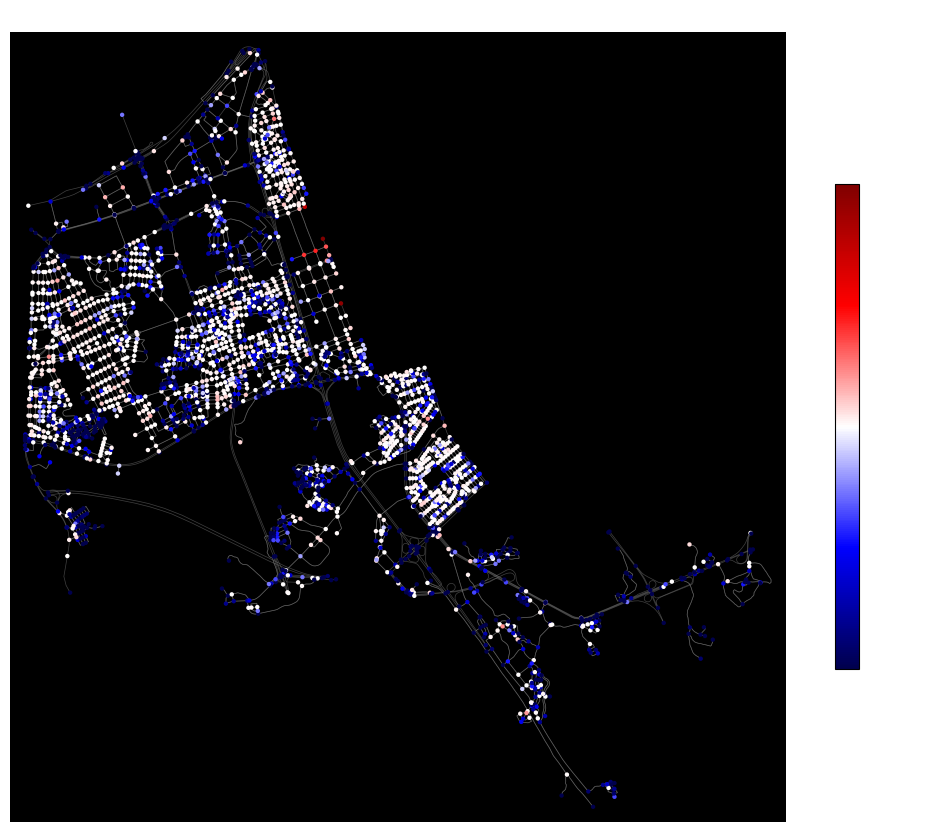

In [6]:
violation_counts = count_viloations_per_node(norm_train, G)

visualize_viloation_counts(G, violation_counts)

In [13]:
def compute_cctv_detection_weights(detection_log, G, now_time, l=0.1):
    """
    CCTV 기반 탐지 이력을 기반으로 그래프 노드별 탐지 중요도 계산
    l : 감소 속도 파라미터
    """
    now_time = pd.to_datetime(now_time)

    # 그래프 노드 위치 정보
    nodes = ox.graph_to_gdfs(G, edges=False)
    node_coords = np.array(list(zip(nodes['y'], nodes['x'])))
    tree = cKDTree(node_coords)

    # 유효탐지 로그 필터링
    df = detection_log.copy()
    df['단속일시'] = pd.to_datetime(df['단속일시'], errors='coerce')
    df = df.dropna(subset=['위도', '경도', '단속일시'])
    df = df[df['단속일시'] <= now_time]

    if df.empty:
        print("탐지 로그가 현재 시각 이전 데이터가 없습니다.")
        return {}

    # 위치 -> 최근접 노드 매핑
    coords =  df[['위도', '경도']].values
    _, idx = tree.query(coords, k=1)
    nearest_node_ids = nodes.iloc[idx].index
    df['node_id'] = nearest_node_ids

    # 시간 가중치 계산 (최근일수록 높게)
    df['time_diff'] = (now_time - df['단속일시']).dt.total_seconds() / 3600  # 단위: 시간
    df['weight'] = np.exp(-l * df['time_diff'])

    # 노드별 가중치 합산
    node_weights = df.groupby('node_id')['weight'].sum().to_dict()

    return node_weights

In [16]:
def visualize_detection_weights(G, node_weights, colormap='Reds', title='CCTV 실시간 탐지 중요도'):
    """
    노드별 실시간 탐지 가중치를 시각화 (빨강=높음, 흰색=낮음)

    Parameters:
        G (networkx.Graph): 도로망 그래프
        node_weights (dict): 노드 ID → 실시간 탐지 중요도
        colormap (str): matplotlib colormap 이름
        title (str): 시각화 제목
    """

    # 1. 그래프에 weight 적용
    for node in G.nodes:
        G.nodes[node]['weight'] = node_weights.get(node, 0)

    weights = np.array([G.nodes[n]['weight'] for n in G.nodes])
    if weights.max() == 0:
        print("⚠️ 모든 노드의 weight가 0입니다. 시각화할 내용이 없습니다.")
        return

    # 2. 정규화 및 색상 매핑 (흰색~빨강)
    norm = colors.Normalize(vmin=weights.min(), vmax=weights.max())
    cmap = cm.get_cmap(colormap)
    node_colors = [cmap(norm(G.nodes[n]['weight'])) for n in G.nodes]

    # 3. 그래프 시각화
    fig, ax = ox.plot_graph(
        G,
        node_color=node_colors,
        node_size=10,
        node_zorder=2,
        bgcolor='black',
        edge_color='gray',
        edge_linewidth=0.5,
        edge_alpha=0.5,
        show=False,
        close=False,
        figsize=(10, 10)
    )

    # 4. 컬러바
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
    cbar.set_label("실시간 탐지 중요도", color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    plt.title(title, color='white')
    plt.tight_layout()
    plt.show()


In [21]:
cctv_train['단속일시'] = pd.to_datetime(cctv_train['단속일시'])

cctv_train['단속일시'].max

<bound method Series.max of 74191    2022-11-23 08:43:00
127987   2023-06-28 14:33:00
146537   2023-09-13 21:34:00
122500   2023-06-02 21:36:00
92627    2023-02-01 16:05:00
                 ...        
122111   2023-05-31 21:12:00
83698    2022-12-28 08:03:00
19678    2022-04-05 21:41:00
94192    2023-02-06 22:08:00
33645    2022-06-03 14:32:00
Name: 단속일시, Length: 114725, dtype: datetime64[ns]>

C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\3231307236.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\3231307236.py:50: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\3231307236.py:50: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\3231307236.py:50: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chobh\AppData\Local\Temp\ipykernel_18004\3231307236.py:50: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from font(s) DejaVu Sans.
  plt

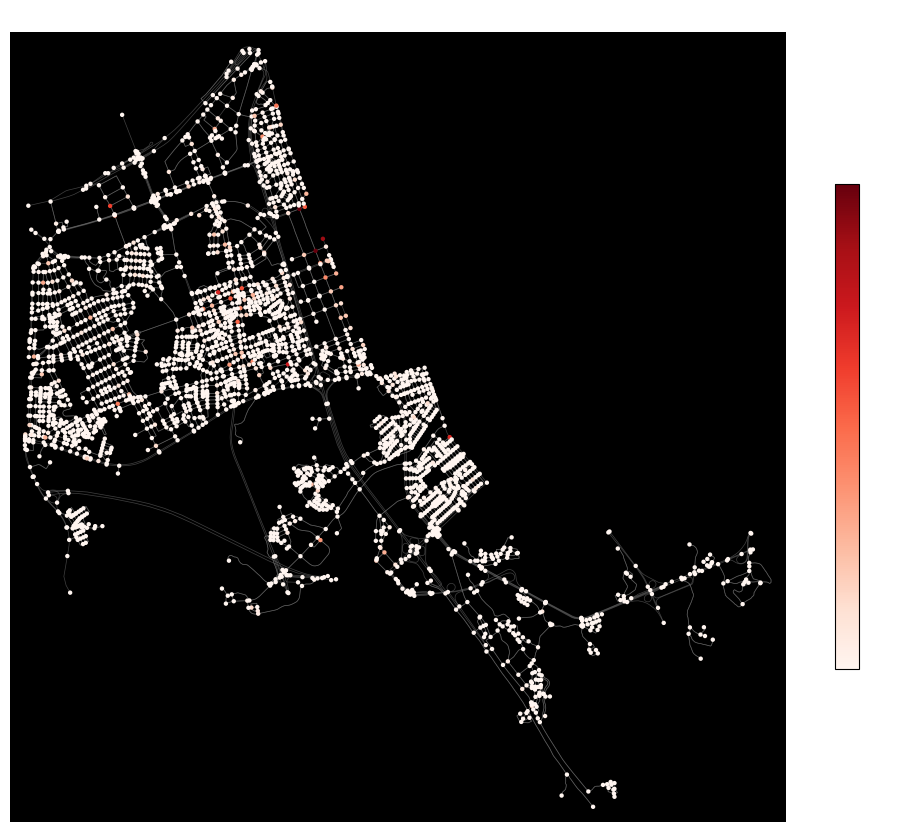

In [25]:
now = '2023-06-28 14:33:00'

node_weights = compute_cctv_detection_weights(cctv_train, G, now, l=0.001)

visualize_detection_weights(G, node_weights)

In [ ]:
## 그래프 예시

# from geopy.distance import geodesic
# import networkx as nx

# # 노드 정의
# locations = {
#     "A": (37.492, 127.01),
#     "B": (37.493, 127.012),
#     "C": (37.495, 127.015)
# }

# G = nx.Graph()
# for name, coord in locations.items():
#     G.add_node(name, lat=coord[0], lon=coord[1])

# # 거리 기반 엣지 추가
# for n1 in locations:
#     for n2 in locations:
#         if n1 != n2:
#             dist = geodesic(locations[n1], locations[n2]).meters
#             G.add_edge(n1, n2, distance=dist)


노드 수: 3057, 엣지 수: 8550


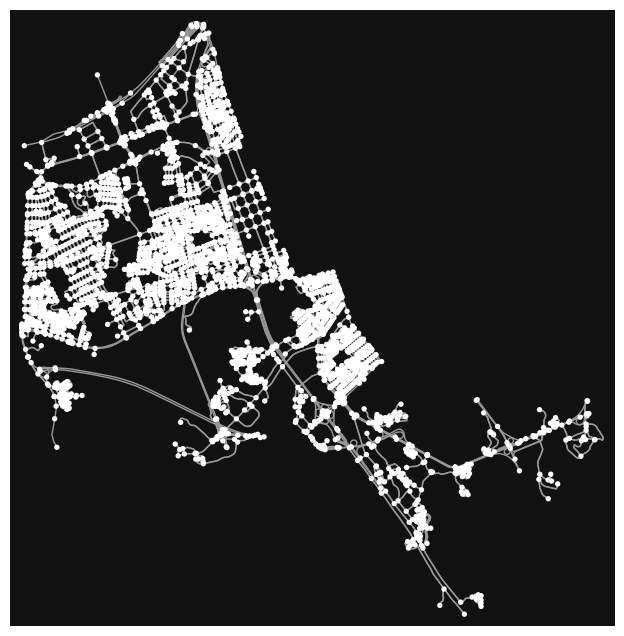

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [3]:
# 1. 서초구의 도로망 그래프 불러오기
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')

# 2. 기본 정보 출력
print(f"노드 수: {len(G.nodes)}, 엣지 수: {len(G.edges)}")

# 3. 시각화 (선택)
ox.plot_graph(G, figsize=(8,8))

In [ ]:
# 전국 cctv 정보
cctv_info = pd.read_excel("../../../Data/전국CCTV표준데이터.xlsx")
cctv_info.head(3)

In [ ]:
# 1. 서초구 도로망 가져오기
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')

# 2. 그래프 → GeoDataFrame 변환
nodes, edges = ox.graph_to_gdfs(G)

# 3. 지도 생성
seocho_center = [37.4836, 127.0326]
m = folium.Map(location=seocho_center, zoom_start=13)

# 4. 도로 엣지 시각화 (파란 선)
for _, row in edges.iterrows():
    coords = [(lat, lon) for lon, lat in row['geometry'].coords]
    folium.PolyLine(locations=coords, color='blue', weight=2, opacity=0.6).add_to(m)

# 5. 노드 시각화 (초록 점)
for node_id, row in nodes.iterrows():
    lat, lon = row['y'], row['x']
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='green',
        fill=True,
        fill_opacity=0.7,
        popup=f"Node ID: {node_id}"
    ).add_to(m)

# 6. CCTV 마커 시각화 (빨간 마커)
cctv_info = pd.read_excel("../../../Data/전국CCTV표준데이터.xlsx")
seocho_cctv = cctv_info[cctv_info['소재지도로명주소'].str.contains("서초구", na=False)]

for _, row in seocho_cctv.iterrows():
    lat, lon = row['WGS84위도'], row['WGS84경도']
    popup_text = f"{row['소재지도로명주소']}<br>카메라: {row['카메라대수']}대"
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color='red', icon='camera')
    ).add_to(m)

# 7. 저장 또는 출력
m.save("seocho_full_graph_with_cctv_nodes.html")
m

In [ ]:
# 서초구 개별 주정차단속 현황
illegal_info = pd.read_csv("../../../Data/2201-2312개별서초구주정차단속현황.csv", encoding='cp949')
illegal_info = illegal_info[illegal_info['단속장소'].notnull()]

# test 데이터 분리 (23.12월 자료)
# illegal_info = illegal_info[illegal_info['단속일시'].notnull()]
illegal_info.head(3)

In [ ]:
tqdm.pandas()

def get_latlon_from_address(address):
    try:
        loc = ox.geocode(address)
        return loc[0], loc[1]
    except:
        return None, None
    
illegal_info[['lat', 'lon']] = illegal_info['단속장소'].progress_apply(lambda x: pd.Series(get_latlon_from_address(x)))

In [ ]:
G = ox.graph_from_place("Seocho-gu, Seoul, South Korea", network_type='drive')

illegal_info['node'] = illegal_info.apply(lambda row: ox.distance.nearest_nodes(G, row['lon'], row['lat']) if pd.notnull(row['lat']) else None, axis=1)

